<font color=red>로지스틱 회귀도 회귀를 쓰기에 분포도가 중요한듯 -> 사용할 때 주의해서 다른 분류기와 비교해볼 것</font> 

<font color=red>cv, gridsearchcv</font>

<font color=red>random_state 고정 -> 최종은 풀어서 해야 하나? 붓꽃에서 0하면 정확도가 1나옴</font>

<font color=red> 데이터가 많을수록 cv는? 18000건 정도면</font>

<font color=red>n_estimators 값이 바뀌면 하이퍼 파라미터 값 바뀌나?</font>

<font color=red>19000건의 데이터인데, cv값은?</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xgboost
xgboost.__version__

'1.7.5'

In [ ]:
import lightgbm
print(lightgbm.__version__)

3.3.5


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import VotingClassifier

import xgboost
from xgboost import plot_importance
from xgboost import XGBClassifier

from lightgbm import LGBMClassifier
from lightgbm import plot_importance

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris

from matplotlib import rc    # 기본 폰트 설정
rc('font', family='Malgun Gothic')

%matplotlib inline

1. 리프 노드의 조건
- 최종 클래스(레이블) 값이 결정되거나(=오직 하나의 클래스 값으로 최종 데이터가 구성)
- 리프 노드가 될 수 있는 하이퍼 파라미터 조건을 충족하거나

2. 결정 트리 파라미터
- min_samples_split
- min_samples_leaf
- max_features
- max_depth
- max_leaf-nodes

3. 속성
- _feature_importances_

4. 결정 트리는 과적합이 상당히 높은 ML 알고리즘이다
- 모든 데이터 상황을 만족하는 완벽한 규칙은 만들 수도 없고, 그렇게 복잡한 학습 모델은 일반화 성능이 떨어진다(과적합 문제)

### 앙상블 학습
#### 장점
- ML 모델의 성능은 이렇게 다양한 테스트 데이터에 의해 검증되므로 어떻게 높은 유연성을 가지고 현실에 대처할 수 있는가가 중요한 ML모델의 평가요소가 됩니다. 이런 관점에서 편향-분산 트레이드오프는 ML모델이 극복해야 할 중요 과제입니다. 보팅과 스태킹 등은 서로 다른 알고리즘을 기반으로 하고 있지만, 배깅과 부스팅은 대부분 결정 트리 알고리즘을 기반으로 합니다. 결정 트리 알고리즘은 쉽고 직관적인 분류 기준을 가지고 있지만 정확한 예측을 위해 학습 데이터의 예외 상황에 집착한 나머지 오히려 과적합이 발생해 실제 테스트 데이터에서 예측 성능이 떨어지는 현상이 발생하기 쉽다고 앞에서 말했습니다. 하지만 앙상블 학습에서는 이 같은 결정 트리 알고리즘의 단점을 수십~수천 개의 매우 많은 분류기를 결합해 다양한 상황을 학습하게 함으로써 극복하고 있습니다. 결정 트리 알고리즘의 장점은 그대로 취하고 단점은 보완하면서 편향-분산 트레이드오프의 효과를 극대화할 수 있다는 것입니다.

#### 유형
1. Voting 유형

2. Bagging 유형 - 랜덤 포레스트 (각은 분류기, 알고리즘, 그러나 데이터 샘플링 다르게 가져감)

3. Boosting 유형 (bootstrap aggregating)
- 그래디언트 부스팅 -> XGBoost, LightGBM
- 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 올바르게 예측할 수 있도록 다음 분류기에게는 가중치(weight)를 부여하면서 학습과 예측을 진행하는 것
- 경사 하강법 - 반복 수행을 통해 오류를 최소화할 수 있도록 가중치의 업데이트 값을 도출하는 기법

4. Stacking
- 여러 가지 모델의 결과를 기반으로 메타 모델을 수립
- 여러 가지 다른 모데르이 예측 결괏값을 다시 학습 데이터로 만들어서 다른 모델(메타 모델)로 재학습시켜 결과를 예측하는 방법

랜덤 포레스트
1. 방식
- 배깅 방식으로 여러 개의 결정 트리 분류기가 전체 데이터에서 각자의 데이터를 샐플링해 개별적으로 학습을 수행
- 최종적으로 모든 분류기가 보팅을 통해 예측 결정을 함(보통 소프트 보팅->평균 방식)

2. 파라미터
- n_estimators - 디폴트는 10개
- max_features
- max_depth, min_samples_leaf, min_sampled_split (결정트리와 동일)


GBM 하이퍼 파라미터
- n_estimators
- max_depth- max_features
- loss
- learning_rate
- subsample

XGBoost (병렬 학습 가능 - 빠른 수행 시간, 과적합 규제)
-



In [ ]:
 GBM = ['n_estimators', 'max_depth', 'max_features', 'loss', 'learning_rate', 'subsample']

하이퍼 파라미터

1. DecisionTreeClassifier
- max_depth, min_samples_leaf, min_sampled_split

2. RandomForest
- Decision과 유사, + n_estimators

3. XGBoost
- n_estimators
- 조기중단 설정이 과적합도 예방하나? 그렇다면 이것도 설정해 줘야 함

속성
- feature_importances : DecisionTree, RandomForest
-

# 롤링 포워드 예측, 워크인 포워드 예측 - 이전 분기를 학습하고 다음 분기를 예측하는 방식

주어진 시나리오에서 Q1부터 계속해서 이전 분기를 학습하고 다음 분기를 예측하는 방식은 "롤링 포워드 예측" 또는 "워크인 포워드 예측"라고도 불립니다. 이러한 방법은 시계열 데이터 예측에서 일반적으로 사용되는 방법 중 하나입니다.

롤링 포워드 예측은 이전 분기의 데이터를 사용하여 다음 분기를 예측하는 방식이기 때문에, 이전 분기의 데이터와 다음 분기의 예측값을 반복해서 사용하여 모델을 학습시키는 특징을 가지고 있습니다. 이로 인해 모델은 시간의 흐름에 따른 패턴을 파악하고 예측할 수 있습니다.

하지만 이 방식은 자체적으로 일종의 "자기 상관성"을 가지고 있기 때문에, 과거의 데이터에 너무 의존할 수 있고, 오버피팅의 위험이 있을 수 있습니다. 따라서 적절한 모델 선택, 데이터 전처리, 파라미터 튜닝 등의 조치를 통해 오버피팅을 방지하고 예측 성능을 향상시켜야 합니다.

모델의 성능과 안정성을 평가하기 위해 교차 검증(Cross Validation)이나 다른 성능 평가 지표를 활용하여 모델의 일반화 성능을 확인하는 것이 좋습니다. 또한, 실제 데이터와 예측 결과를 비교하고 모델의 예측력을 평가하는 것도 중요합니다.

따라서 롤링 포워드 예측을 사용할 때에는 주의가 필요하며, 적절한 모델 선택과 파라미터 튜닝, 데이터 전처리 등을 통해 과적합을 피하고 예측 성능을 최적화해야 합니다.

----------------------------

그런데 이런 예측 방식에서 교차 검증은 할 수 없잖아 다음 분기를 예측하는거라 교차검증이 안될 것 같은데

-------------------------------
옳은 말씀이십니다. 롤링 포워드 예측 방식에서는 다음 분기를 예측하는데 사용되기 때문에 전통적인 교차 검증 기법을 직접적으로 적용하는 것은 어렵습니다. 교차 검증은 일반적으로 현재 시점에서 과거 데이터를 학습하고 미래 데이터를 검증하는 방식으로 수행됩니다.

롤링 포워드 예측에서는 시간적인 순서를 유지해야 하므로, 예측 과정에서 다음 분기를 학습 데이터에 포함시키지 않고 예측만 수행하는 것이 일반적입니다. 그러나 모델의 성능을 평가하고 예측의 정확도를 판단하기 위해서는 추가적인 방법을 고려해야 합니다.

일반적인 접근 방법은 과거 데이터를 여러 블록으로 나눈 후, 각 블록에 대해 학습과 검증을 수행하는 것입니다. 예를 들어, 초기 블록을 학습하고 다음 블록에 대한 예측을 수행한 후, 이 과정을 반복하여 모든 블록에 대한 예측을 완료합니다. 이렇게 여러 번의 예측을 수행하고 예측 결과를 평균하여 최종 예측을 얻을 수 있습니다.

이러한 방식은 교차 검증과 유사한 효과를 내며, 모델의 안정성과 예측력을 평가하는 데 도움이 됩니다. 또한, 모델의 파라미터 튜닝이나 기타 전처리 작업을 수행할 때에도 위와 같은 방식을 활용하여 최적의 설정을 찾을 수 있습니다.

요약하면, 롤링 포워드 예측에서는 전통적인 교차 검증을 직접적으로 사용하기는 어렵지만, 시계열 데이터의 특성을 고려하여 예측 결과를 평가하고 모델을 개선할 수 있는 방법을 활용할 수 있습니다.

In [152]:
X_train_5Q = pd.read_excel('X_train_1-5Q.xlsx', index_col=0)
# X_test_6Q = pd.read_excel('X_test_6Q.xlsx', index_col=0)
X_validation_6Q = pd.read_excel('X_test_1-6Q.xlsx', index_col=0)
pd.set_option('display.max_columns', None)

# X_test_7Q = pd.read_excel('X_test_7Q.xlsx', index_col=0)
X_test_7Q = pd.read_excel('X_test_1-7Q.xlsx', index_col=0)

In [115]:
X_train_5Q.head(2)

,성별,연령대,거주지역,A_Sum,A_Abs_Sum,B_Sum,B_Abs_Sum,C_Sum,C_Abs_Sum,D_Sum,D_Abs_Sum,가공_Sum,가공_Abs_Sum,신선_Sum,신선_Abs_Sum,외식/편의시설_Sum,외식/편의시설_Abs_Sum,일상_Sum,일상_Abs_Sum,가구_Sum,가구_Abs_Sum,스포츠_Sum,스포츠_Abs_Sum,의류_Sum,의류_Abs_Sum,패션잡화_Sum,패션잡화_Abs_Sum,유아/아동_Sum,유아/아동_Abs_Sum,명품_Sum,명품_Abs_Sum,가전_Sum,가전_Abs_Sum,교육/문화_Sum,교육/문화_Abs_Sum,뷰티_Sum,뷰티_Abs_Sum,의료_Sum,의료_Abs_Sum,TOTAL_Sum,TOTAL_Abs_Sum,VIS_Sum,VIS_Abs_Sum,TMOR_Sum,TMOR_Abs_Sum,TLUN_Sum,TLUN_Abs_Sum,TAFT_Sum,TAFT_Abs_Sum,TEVE_Sum,TEVE_Abs_Sum,TMID_Sum,TMID_Abs_Sum,CAGR,RECENCY,6Q_TARGET
1,M,60세이상,1.0,0,2,2,4,4,10,0,0,4,8,2,12,-3,15,-1,19,0,0,0,18,0,0,1,7,-5,5,4,4,6,12,0,0,-1,1,-9,9,-1,1,2,4,3,15,0,2,-1,1,5,9,0,0,0.004385,1,1
2,M,60세이상,100.0,0,6,1,1,0,0,0,0,-5,7,0,0,0,0,-2,6,7,7,0,6,2,4,1,5,4,18,6,6,2,18,0,0,0,0,0,14,0,2,-1,9,0,26,0,2,0,2,1,11,0,0,0.069544,1,1


In [109]:
X_validation_6Q.head(2)

,성별,연령대,거주지역,A_Sum,A_Abs_Sum,B_Sum,B_Abs_Sum,C_Sum,C_Abs_Sum,D_Sum,D_Abs_Sum,가공_Sum,가공_Abs_Sum,신선_Sum,신선_Abs_Sum,외식/편의시설_Sum,외식/편의시설_Abs_Sum,일상_Sum,일상_Abs_Sum,가구_Sum,가구_Abs_Sum,스포츠_Sum,스포츠_Abs_Sum,의류_Sum,의류_Abs_Sum,패션잡화_Sum,패션잡화_Abs_Sum,유아/아동_Sum,유아/아동_Abs_Sum,명품_Sum,명품_Abs_Sum,가전_Sum,가전_Abs_Sum,교육/문화_Sum,교육/문화_Abs_Sum,뷰티_Sum,뷰티_Abs_Sum,의료_Sum,의료_Abs_Sum,VIS_Sum,VIS_Abs_Sum,TMOR_Sum,TMOR_Abs_Sum,TLUN_Sum,TLUN_Abs_Sum,TAFT_Sum,TAFT_Abs_Sum,TEVE_Sum,TEVE_Abs_Sum,TMID_Sum,TMID_Abs_Sum,CAGR,RECENCY,7Q_TARGET
1,M,60세이상,1.0,0,2,0,6,5,11,0,0,1,11,1,13,-3,15,0,20,0,0,-5,23,0,0,-1,9,-5,5,0,8,0,18,0,0,-5,5,-9,9,-3,9,3,15,0,2,-2,2,6,10,0,0,-0.016528,1,1
2,M,60세이상,100.0,-1,7,0,2,0,0,8,8,-9,11,-1,1,0,0,0,8,0,14,-1,7,0,6,-1,7,-5,27,0,12,-6,26,0,0,0,0,0,14,-5,13,-7,33,0,2,0,2,3,13,0,0,-0.100079,1,1


In [107]:
# 최종거 쓰는 것
X_test_7Q.head(2)

,성별,연령대,거주지역,A_Sum,A_Abs_Sum,B_Sum,B_Abs_Sum,C_Sum,C_Abs_Sum,D_Sum,D_Abs_Sum,가공_Sum,가공_Abs_Sum,신선_Sum,신선_Abs_Sum,외식/편의시설_Sum,외식/편의시설_Abs_Sum,일상_Sum,일상_Abs_Sum,가구_Sum,가구_Abs_Sum,스포츠_Sum,스포츠_Abs_Sum,의류_Sum,의류_Abs_Sum,패션잡화_Sum,패션잡화_Abs_Sum,유아/아동_Sum,유아/아동_Abs_Sum,명품_Sum,명품_Abs_Sum,가전_Sum,가전_Abs_Sum,교육/문화_Sum,교육/문화_Abs_Sum,뷰티_Sum,뷰티_Abs_Sum,의료_Sum,의료_Abs_Sum,VIS_Sum,VIS_Abs_Sum,TMOR_Sum,TMOR_Abs_Sum,TLUN_Sum,TLUN_Abs_Sum,TAFT_Sum,TAFT_Abs_Sum,TEVE_Sum,TEVE_Abs_Sum,TMID_Sum,TMID_Abs_Sum,CAGR,RECENCY,8Q_TARGET
1,M,60세이상,1.0,0,2,1,7,0,16,0,0,-1,13,-5,19,2,20,-9,29,0,0,-2,26,0,0,2,12,-5,5,0,8,8,26,0,0,-9,9,-9,9,-3,9,0,18,0,2,-1,3,0,16,0,0,-0.035636,1,1
2,M,60세이상,100.0,0,8,0,2,0,0,6,10,-6,14,-1,1,0,0,0,8,0,14,0,8,2,8,1,9,-1,31,0,12,3,35,0,0,0,0,4,18,-3,15,2,42,0,2,-1,3,5,15,0,0,-0.001839,1,1


In [153]:
y_train = X_train_5Q['6Q_TARGET']
X_train = X_train_5Q.drop(['6Q_TARGET', 'TOTAL_Sum'] , axis=1)    # -> Q1~Q5까지

y_test = X_validation_6Q['7Q_TARGET']
X_test = X_validation_6Q.drop(['7Q_TARGET', 'TOTAL_Sum'], axis=1)

y_test_f = X_test_7Q['8Q_TARGET']
X_test_f= X_test_7Q.drop(['8Q_TARGET', 'TOTAL_Sum'], axis=1)    # -> Q2~Q6까지

In [162]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

X_test['성별'] = label_encoder.fit_transform(X_test['성별'])
X_test['연령대'] = label_encoder.fit_transform(X_test['연령대'])
X_test['거주지역'] = label_encoder.fit_transform(X_test['거주지역'])

X_train['성별'] = label_encoder.fit_transform(X_train['성별'])
X_train['연령대'] = label_encoder.fit_transform(X_train['연령대'])
X_train['거주지역'] = label_encoder.fit_transform(X_train['거주지역'])

X_test_f['성별'] = label_encoder.fit_transform(X_train['성별'])
X_test_f['연령대'] = label_encoder.fit_transform(X_train['연령대'])
X_test_f['거주지역'] = label_encoder.fit_transform(X_train['거주지역'])

In [68]:
# X_train = pd.get_dummies(X_train)    # 최종 테스트시에는 이건 이미 돼있으니까 주석 처리해서 아랫줄만 돌리기
# X_test = pd.get_dummies(X_test)

In [69]:
# # train 데이터셋 거주지역에 사용
# # null 값을 다른 거주지역에 골고루 분배
# nan_count = X_train['거주지역'].isnull().sum()  # null 값의 개수 계산
# nan_indices = X_train['거주지역'].isnull()  # null 값의 인덱스 확인

# unique_values = X_train['거주지역'].dropna().unique()  # null이 아닌 고유한 값들만 추출
# fill_values = np.random.choice(unique_values, size=nan_count, replace=True)  # 무작위로 채울 값 생성

# X_train.loc[nan_indices, '거주지역'] = fill_values  # null 값을 채워넣음

# # '거주지역' 값 빈도 (null 값 포함)
# value_counts = X_train['거주지역'].value_counts(dropna=False)

# # 결과 출력
# value_counts.head(3)

100.0    5853
460.0    1879
55.0     1412
Name: 거주지역, dtype: int64

In [70]:
# # test 데이터셋 거주지역에 사용
# # null 값을 다른 거주지역에 골고루 분배
# nan_count = X_test['거주지역'].isnull().sum()  # null 값의 개수 계산
# nan_indices = X_test['거주지역'].isnull()  # null 값의 인덱스 확인

# unique_values = X_test['거주지역'].dropna().unique()  # null이 아닌 고유한 값들만 추출
# fill_values = np.random.choice(unique_values, size=nan_count, replace=True)  # 무작위로 채울 값 생성

# X_test.loc[nan_indices, '거주지역'] = fill_values  # null 값을 채워넣음

# # '거주지역' 값 빈도 (null 값 포함)
# value_counts = X_test['거주지역'].value_counts(dropna=False)

# # 결과 출력
# value_counts.head(3)

100.0    5846
460.0    1878
55.0     1409
Name: 거주지역, dtype: int64

In [71]:
# X_train = pd.get_dummies(X_train, columns=['거주지역'])    # 최종 테스트시에는 이건 이미 돼있으니까 주석 처리해서 아랫줄만 돌리기
# X_test = pd.get_dummies(X_test, columns=['거주지역'])

In [156]:
X_train.head(2)
# X_test

,성별,연령대,거주지역,A_Sum,A_Abs_Sum,B_Sum,B_Abs_Sum,C_Sum,C_Abs_Sum,D_Sum,D_Abs_Sum,가공_Sum,가공_Abs_Sum,신선_Sum,신선_Abs_Sum,외식/편의시설_Sum,외식/편의시설_Abs_Sum,일상_Sum,일상_Abs_Sum,가구_Sum,가구_Abs_Sum,스포츠_Sum,스포츠_Abs_Sum,의류_Sum,의류_Abs_Sum,패션잡화_Sum,패션잡화_Abs_Sum,유아/아동_Sum,유아/아동_Abs_Sum,명품_Sum,명품_Abs_Sum,가전_Sum,가전_Abs_Sum,교육/문화_Sum,교육/문화_Abs_Sum,뷰티_Sum,뷰티_Abs_Sum,의료_Sum,의료_Abs_Sum,TOTAL_Abs_Sum,VIS_Sum,VIS_Abs_Sum,TMOR_Sum,TMOR_Abs_Sum,TLUN_Sum,TLUN_Abs_Sum,TAFT_Sum,TAFT_Abs_Sum,TEVE_Sum,TEVE_Abs_Sum,TMID_Sum,TMID_Abs_Sum,CAGR,RECENCY
1,1,9,0,0,2,2,4,4,10,0,0,4,8,2,12,-3,15,-1,19,0,0,0,18,0,0,1,7,-5,5,4,4,6,12,0,0,-1,1,-9,9,1,2,4,3,15,0,2,-1,1,5,9,0,0,0.004385,1
2,1,9,1,0,6,1,1,0,0,0,0,-5,7,0,0,0,0,-2,6,7,7,0,6,2,4,1,5,4,18,6,6,2,18,0,0,0,0,0,14,2,-1,9,0,26,0,2,0,2,1,11,0,0,0.069544,1


In [ ]:
# # train 데이터셋 PCA에 사용

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # 'TOTAL_Sum'과 'CAGR' 피처 선택
# selected_features = ['TOTAL_Sum', 'CAGR']

# # StandardScaler 인스턴스 생성 및 적용
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train[selected_features])

# # PCA 인스턴스 생성 및 적용
# pca = PCA(n_components=1)
# X_train_pca = pca.fit_transform(X_train_scaled)

# # 'TOTAL_Sum'과 'CAGR' 컬럼 삭제
# X_train.drop(selected_features, axis=1, inplace=True)

# # PCA로 차원 축소한 값을 X_train에 추가
# X_train['PCA'] = X_train_pca


In [222]:
# # test 데이터셋 PCA에 사용

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # 'TOTAL_Sum'과 'CAGR' 피처 선택
# selected_features = ['TOTAL_Sum', 'CAGR']

# # StandardScaler 인스턴스 생성 및 적용
# scaler = StandardScaler()
# X_test_scaled = scaler.fit_transform(X_test[selected_features])

# # PCA 인스턴스 생성 및 적용
# pca = PCA(n_components=1)
# X_test_pca = pca.fit_transform(X_test_scaled)

# # 'TOTAL_Sum'과 'CAGR' 컬럼 삭제
# X_test.drop(selected_features, axis=1, inplace=True)

# # PCA로 차원 축소한 값을 X_train에 추가
# X_test['PCA'] = X_test_pca

In [224]:
# # PCA 검증
# pca.explained_variance_ratio_

array([0.87818432])

In [163]:
# y_l_df = l_df['target']
# X_l_df= l_df.drop('target', axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X_l_df, y_l_df, \
#                                                     test_size=0.20, random_state=0)

# #
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )
evals = [(X_tr, y_tr), (X_val, y_val)]    # 성능을 평가하기 위해 사용하는 데이터셋

# LogisticRegression 클래스 생성과 학습/예측/평가
dt_clf = DecisionTreeClassifier(random_state=0)   # solver - 최적화 알고리즘을 지정하는 매개변수
                                                   # 작은 데이터 세트에서의 이진분류능 liblinear가 성능이
                                                   # 약간 더 좋음
lr_clf = LogisticRegression(solver='liblinear', random_state=0)
rf_clf = RandomForestClassifier(random_state=0)
# xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper = XGBClassifier(random_state=0)
# lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05, random_state=0)
lgbm_wrapper = LGBMClassifier(random_state=0)



dt_clf.fit(X_train, y_train)    # DecisionTreeClassifier 객체로 학습
lr_clf.fit(X_train, y_train)    # LogisticRegression 객체로 학습
rf_clf.fit(X_train, y_train)
xgb_wrapper.fit(X_train, y_train)
lgbm_wrapper.fit(X_train, y_train, eval_metric="logloss", eval_set=evals, verbose=False)

dt_pred = dt_clf.predict(X_test)
lr_pred = lr_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
xgb_pred = xgb_wrapper.predict(X_test)
lgbm_pred = lgbm_wrapper.predict(X_test)

dt_pred_f = dt_clf.predict(X_test_f)
lr_pred_f = lr_clf.predict(X_test_f)
rf_pred_f = rf_clf.predict(X_test_f)
xgb_pred_f = xgb_wrapper.predict(X_test_f)
lgbm_pred_f = lgbm_wrapper.predict(X_test_f)

dt_pred_proba = dt_clf.predict_proba(X_test)[:, 1]
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
rf_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
xgb_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
lgbm_pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

dt_pred_proba_f = dt_clf.predict_proba(X_test_f)[:, 1]
lr_pred_proba_f = lr_clf.predict_proba(X_test_f)[:, 1]
rf_pred_proba_f = rf_clf.predict_proba(X_test_f)[:, 1]
xgb_pred_proba_f = xgb_wrapper.predict_proba(X_test_f)[:, 1]
lgbm_pred_proba_f = lgbm_wrapper.predict_proba(X_test_f)[:, 1]

In [170]:
# 하이퍼 파라미터 찾아낸 값 적용한 객체 추가로 생성
dt_clf1 = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1, random_state=2)

dt_clf1.fit(X_train, y_train)    # 추가

dt1_pred = dt_clf1.predict(X_test)    # 추가
dt1_pred_proba = dt_clf1.predict_proba(X_test)[:, 1]    # 추가

dt1_pred_f = dt_clf1.predict(X_test_f)    # 추가
dt1_pred_proba_f = dt_clf1.predict_proba(X_test_f)[:, 1]    # 추가

In [171]:
rf_clf1 = RandomForestClassifier(max_depth=30, min_samples_leaf=5, min_samples_split=2, n_estimators=200, random_state=0)
rf_clf1.fit(X_train, y_train)    # 추가

rf1_pred = rf_clf1.predict(X_test)    # 추가
rf1_pred_proba = rf_clf1.predict_proba(X_test)[:, 1]    # 추가

rf1_pred_f = rf_clf1.predict(X_test_f)    # 추가
rf1_pred_proba_f = rf_clf1.predict_proba(X_test_f)[:, 1]    # 추가

In [172]:
xgb_wrapper1 = XGBClassifier(reg_alpha=5, reg_lambda=1, colsample_bytree=0.9, learning_rate=0.5, max_depth=3, min_child_weight=1, n_estimators=400, subsample=0.6, random_state=0)

xgb_wrapper1.fit(X_train, y_train)

xgb1_pred = xgb_wrapper1.predict(X_test)
xgb1_pred_proba = xgb_wrapper1.predict_proba(X_test)[:, 1]

xgb1_pred_f = xgb_wrapper1.predict(X_test)
xgb1_pred_proba_f = xgb_wrapper1.predict_proba(X_test)[:, 1]

In [173]:
lgbm_wrapper1 = LGBMClassifier(colsample_bytree=0.9, learning_rate=0.1, max_depth=20, min_child_samples=20, min_child_weight=0.001, n_estimators=50, num_leaves=30, reg_alpha=0.1, reg_lambda=1, subsample=0.1, random_state=0)
# lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=False)
lgbm_wrapper1.fit(X_train, y_train, eval_metric='logloss', eval_set=evals, verbose=False)

lgbm1_pred = lgbm_wrapper1.predict(X_test)
lgbm1_pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

lgbm1_pred_f = lgbm_wrapper1.predict(X_test)
lgbm1_pred_proba_f = lgbm_wrapper.predict_proba(X_test)[:, 1]

In [174]:
def get_clf_eval(y_test=None, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    # print('오차 행렬:\n', confusion)
    eval_dict = {'정확도': [accuracy], '정밀도': [precision], '재현율': [recall],
                 'f1 score': [f1], 'AUC': [roc_auc]}

    eval_df = pd.DataFrame(eval_dict)
    return eval_df

In [165]:
# 1Q~7Q 평가수치

import pandas as pd

# 각 classifier의 결과를 저장할 빈 리스트
eval_results = []

# Decision Tree Classifier 결과
dt_eval = get_clf_eval(y_test, dt_pred, dt_pred_proba)
eval_results.append(dt_eval)

# Decision Tree Classifier (hyper) 결과
dt1_eval = get_clf_eval(y_test, dt1_pred, dt1_pred_proba)
eval_results.append(dt1_eval)

# Logistic Regression 결과
lr_eval = get_clf_eval(y_test, lr_pred, lr_pred_proba)
eval_results.append(lr_eval)

# Random Forest Classifier 결과
rf_eval = get_clf_eval(y_test, rf_pred, rf_pred_proba)
eval_results.append(rf_eval)

# Random Forest Classifier (hyper) 결과
rf1_eval = get_clf_eval(y_test, rf1_pred, rf1_pred_proba)
eval_results.append(rf1_eval)

# XGBoost 결과
xgb_eval = get_clf_eval(y_test, xgb_pred, xgb_pred_proba)
eval_results.append(xgb_eval)

# XGBoost (hyper) 결과
xgb1_eval = get_clf_eval(y_test, xgb1_pred, xgb1_pred_proba)
eval_results.append(xgb1_eval)

# LightGBM 결과
lgbm_eval = get_clf_eval(y_test, lgbm_pred, lgbm_pred_proba)
eval_results.append(lgbm_eval)

# LightGBM (hyper) 결과
lgbm1_eval = get_clf_eval(y_test, lgbm1_pred, lgbm1_pred_proba)
eval_results.append(lgbm1_eval)

# 각 classifier의 이름 리스트
classifier_names = ['DecisionTreeClassifier', 'DecisionTreeClassifier (hyper)', 'LogisticRegression', 'RandomForestClassifier', 'RandomForestClassifier (hyper)', 'XGBoost', 'XGBoost (hyper)', 'LightGBM', 'LightGBM (hyper)']

# 결과를 DataFrame으로 변환
eval_df = pd.concat(eval_results, keys=classifier_names)

eval_df

,,정확도,정밀도,재현율,f1 score,AUC
DecisionTreeClassifier,0,0.662250,0.622312,0.646928,0.634381,0.660931
DecisionTreeClassifier (hyper),0,0.737570,0.674331,0.813458,0.737389,0.744099
LogisticRegression,0,0.746634,0.703096,0.762668,0.731672,0.825200
RandomForestClassifier,0,0.751882,0.716738,0.747689,0.731886,0.827844
RandomForestClassifier (hyper),0,0.755645,0.718587,0.756934,0.737262,0.832486
XGBoost,0,0.739902,0.705769,0.730135,0.717745,0.815251
XGBoost (hyper),0,0.720980,0.684720,0.711644,0.697923,0.795867
LightGBM,0,0.749390,0.715820,0.740784,0.728088,0.828551
LightGBM (hyper),0,0.751246,0.715244,0.748976,0.731721,0.827838


In [144]:
eval_df.to_excel('eval_df_거주뺌.xlsx')

In [69]:
eval_df.to_excel('eval_df_cagr만.xlsx')

In [214]:
eval_df.to_excel('eval_df_최종(3-7Q).xlsx')

In [229]:
eval_df.to_excel('eval_df_최종(1-7Q).xlsx')

In [175]:
# 1Q~7Q 평가수치

import pandas as pd

# 각 classifier의 결과를 저장할 빈 리스트
eval_results = []

# Decision Tree Classifier 결과
dt_eval = get_clf_eval(y_test_f, dt_pred_f, dt_pred_proba_f)
eval_results.append(dt_eval)

# Decision Tree Classifier (hyper) 결과
dt1_eval = get_clf_eval(y_test_f, dt1_pred_f, dt1_pred_proba_f)
eval_results.append(dt1_eval)

# Logistic Regression 결과
lr_eval = get_clf_eval(y_test_f, lr_pred_f, lr_pred_proba_f)
eval_results.append(lr_eval)

# Random Forest Classifier 결과
rf_eval = get_clf_eval(y_test_f, rf_pred_f, rf_pred_proba_f)
eval_results.append(rf_eval)

# Random Forest Classifier (hyper) 결과
rf1_eval = get_clf_eval(y_test_f, rf1_pred_f, rf1_pred_proba_f)
eval_results.append(rf1_eval)

# XGBoost 결과
xgb_eval = get_clf_eval(y_test_f, xgb_pred_f, xgb_pred_proba_f)
eval_results.append(xgb_eval)

# XGBoost (hyper) 결과
xgb1_eval = get_clf_eval(y_test_f, xgb1_pred_f, xgb1_pred_proba_f)
eval_results.append(xgb1_eval)

# LightGBM 결과
lgbm_eval = get_clf_eval(y_test_f, lgbm_pred_f, lgbm_pred_proba_f)
eval_results.append(lgbm_eval)

# LightGBM (hyper) 결과
lgbm1_eval = get_clf_eval(y_test_f, lgbm1_pred_f, lgbm1_pred_proba_f)
eval_results.append(lgbm1_eval)

# 각 classifier의 이름 리스트
classifier_names = ['DecisionTreeClassifier', 'DecisionTreeClassifier (hyper)', 'LogisticRegression', 'RandomForestClassifier', 'RandomForestClassifier (hyper)', 'XGBoost', 'XGBoost (hyper)', 'LightGBM', 'LightGBM (hyper)']

# 결과를 DataFrame으로 변환
eval_df = pd.concat(eval_results, keys=classifier_names)

eval_df

,,정확도,정밀도,재현율,f1 score,AUC
DecisionTreeClassifier,0,0.620004,0.699343,0.584109,0.636553,0.625819
DecisionTreeClassifier (hyper),0,0.746899,0.786750,0.762374,0.774370,0.744392
LogisticRegression,0,0.730521,0.797229,0.706736,0.749260,0.815541
RandomForestClassifier,0,0.720078,0.808139,0.667008,0.730822,0.814708
RandomForestClassifier (hyper),0,0.726439,0.806204,0.684313,0.740275,0.821553
XGBoost,0,0.701739,0.797214,0.639003,0.709394,0.800939
XGBoost (hyper),0,0.697551,0.784794,0.646353,0.708878,0.785321
LightGBM,0,0.718488,0.810296,0.660495,0.727767,0.820393
LightGBM (hyper),0,0.718223,0.804416,0.667752,0.729741,0.810555


In [54]:
# GridSearchCV에서 scoring 기본값
    # 회귀 모델인 경우: 'neg_mean_squared_error' (음수로 표기된 평균 제곱 오차)
    # 분류 모델인 경우: 'accuracy' (정확도)
# cv는 많을수록 일반화 검증이 더 정확하며, 많으면 10~20까지 정도 해도 되는듯

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
    # grid_model.fit(X_features, y_target)
    grid_model.fit(X_train, y_train)
    print('최적 하이퍼 파라미터:\n', grid_model.best_params_)
    print('최고 예측 정확도: {0:.4f}'.format(grid_model.best_score_))
#     scores_df = pd.DataFrame(grid_model.cv_results_)
#     print(scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score',
#               'split3_test_score', 'split4_test_score']])

    return grid_model.best_estimator_

In [230]:
print(dt_clf.tree_.max_depth)
dt_clf.get_params()

36


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

In [234]:
# DecisionTree에는 n_estimators, n_jobs 없음)
# 기존 40depth
# cv=5일 때 -> 5, 15, 2
dt_clf_params = {
    'max_depth' : [1],
    'min_samples_leaf' : [1],
    'min_samples_split' : [2],
}

best_dt_clf = print_best_params(dt_clf, dt_clf_params)
best_dt_clf

최적 하이퍼 파라미터:
 {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
최고 예측 정확도: 0.7350


DecisionTreeClassifier(max_depth=1, random_state=0)

In [80]:
# RandomForest
# 기존 37depth

first_tree = rf_clf.estimators_[0]
print(first_tree.tree_.max_depth)
rf_clf.get_params()

33


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [83]:
# RandomForest
# cv가 달라지면 최적화 값도 달라지는가? -> 그런것 같음
# 작은 데이터셋 -> 더 정확한 평가 위해 10폴드 정도 (수백개 이하)
# 큰 데이터셋 -> 더 정확한 평가 위해 5폴드 정도 (천 개 이상)


rf_clf_params = {
    'max_depth' : [30],
    'min_samples_leaf' : [5],
    'min_samples_split' : [2],
    'n_estimators' : [200]
}

best_rf_clf = print_best_params(rf_clf, rf_clf_params)
best_rf_clf

최적 하이퍼 파라미터:
 {'max_depth': 30, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 180}
최고 예측 정확도: 0.7395


RandomForestClassifier(max_depth=30, min_samples_leaf=5, n_estimators=180,
                       random_state=0)

In [ ]:
lr_clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Logistic Regression

lr_clf_params = {
#     'solver' : ['liblinear', 'lbfgs', 'newton-cg', 'sga', 'saga'],
    'solver' : ['liblinear', 'lbfgs'],
    'penalty' : ['l2', 'l1'],
    'C' : [0.01, 0.1, 1, 5, 10],
    'max_iter : [600]'
}

best_lr_clf = print_best_params(lr_clf, lr_clf_params)
best_lr_clf

In [ ]:
xgb_wrapper.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 400,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# min_child_weight - 높을수록 과적합 방지
# sub_sample - 보통 0.5~1사이의 값 사용
# colsample_bytree - 보통 0.6~0.9
# reg_lambda - L2 적용 값 (피처 개수가 많을 경우, 값이 클수록 과적합 감소 효과)
# reg_alpha - L1 적용값 (피처 개수가 많을 경우, 값이 클수록 과적합 감소 효과)
# xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
# reg_lambda - 작은 값:0.1미만의 값, 중간 값:0.1~1.0 사이의 값, 큰 값:0.1 이상의 값
# reg_alpha = 0.01, 0.1, 1, 10과 같이 거듭제곱 단위로 설정
# 1:43:17초 걸림
# 1차 -  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'num_leaves': 35, 'subsample': 0.8}
# 최고 예측 정확도: 0.8287

xgb_wrapper_params = {
    'max_depth' : [3, 5, 7],
    'learning_rate' : [0.1, 0.3, 0.5],
    'min_child_weight' : [1, 5, 10],
    'colsample_bytree' : [0.5, 0.6, 0.7, 0.8, 0.9],
    'subsample' : [0.5, 0.6, 0.7, 0.8, 0.9],
    'n_estimators' : [200, 400, 600],
    'reg_lambda' : [0.1, 1, 3],
    'reg_alpha' : [0.01, 0.1, 5]
}

best_xgb_wrapper = print_best_params(xgb_wrapper, xgb_wrapper_params)
best_xgb_wrapper

최적 하이퍼 파라미터:
 {'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 5, 'reg_lambda': 1, 'subsample': 0.6}
최고 예측 정확도: 0.8328


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [ ]:
# 2차
# learning_rate = 0.5 / n_estimators=400 / reg_alpha 5 / reg_lambda 1

xgb_wrapper_params = {
    'max_depth' : [3],
    'learning_rate' : [0.5],
    'min_child_weight' : [1],
    'colsample_bytree' : [0.9],
    'subsample' : [0.6],
    'n_estimators' : [400],
    'reg_lambda' : [1],
    'reg_alpha' : [5]
}

best_xgb_wrapper = print_best_params(xgb_wrapper, xgb_wrapper_params)
best_xgb_wrapper

최적 하이퍼 파라미터:
 {'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400, 'reg_alpha': 5, 'reg_lambda': 1, 'subsample': 0.6}
최고 예측 정확도: 0.8328


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [52]:
lgbm_wrapper.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [55]:
lgbm_wrapper_params = {
    'max_depth' : [15, 20, 25],
    'learning_rate' : [0.1, 0.2, 0.3],
    'min_child_weight' : [0.001, 0.005],
    'num_leaves' : [25, 30, 35],
    'colsample_bytree' : [0.8, 0.9, 1],
    'subsample' : [0.1, 0.3, 0.5],
    'n_estimators' : [10, 30, 50],
    'min_child_samples' : [15, 20, 25],
    'reg_lambda' : [1, 2],
    'reg_alpha' : [0.1, 0.2]
}


best_lgbm_wrapper = print_best_params(lgbm_wrapper, lgbm_wrapper_params)
best_lgbm_wrapper

최적 하이퍼 파라미터:
 {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 20, 'min_child_weight': 0.001, 'n_estimators': 50, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.5}
최고 예측 정확도: 0.7394


LGBMClassifier(colsample_bytree=0.9, max_depth=20, n_estimators=50,
               num_leaves=30, random_state=0, reg_alpha=0.1, reg_lambda=1,
               subsample=0.5)

In [59]:
# 2차

lgbm_wrapper_params = {
    'max_depth' : [20],
    'learning_rate' : [0.1],
    'min_child_weight' : [0.001],
    'num_leaves' : [30],
    'colsample_bytree' : [0.9],
    'subsample' : [0.1],
    'n_estimators' : [50],
    'min_child_samples' : [20],
    'reg_lambda' : [1],
    'reg_alpha' : [0.1]
}


best_lgbm_wrapper = print_best_params(lgbm_wrapper, lgbm_wrapper_params)
best_lgbm_wrapper

최적 하이퍼 파라미터:
 {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 20, 'min_child_weight': 0.001, 'n_estimators': 50, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.1}
최고 예측 정확도: 0.7394


LGBMClassifier(colsample_bytree=0.9, max_depth=20, n_estimators=50,
               num_leaves=30, random_state=0, reg_alpha=0.1, reg_lambda=1,
               subsample=0.1)

In [241]:
# sns.barplot(x=dt_clf.feature_importances_, y=X_test.columns)
sorted_importances
# sorted_features

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

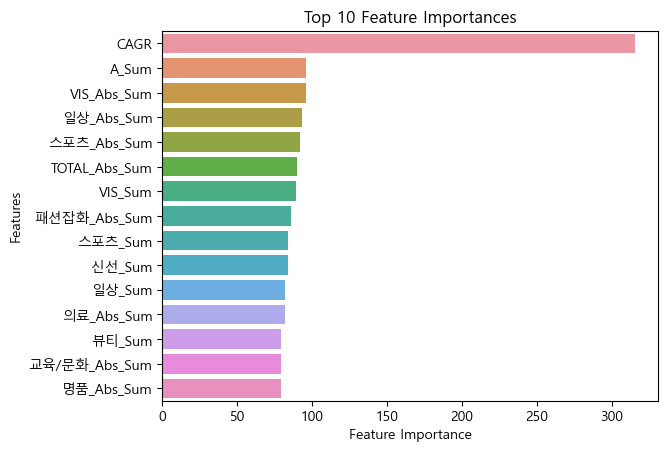

In [65]:
# Sort feature importances in descending order
sorted_indices = np.argsort(lgbm_wrapper.feature_importances_)[::-1]
sorted_importances = lgbm_wrapper.feature_importances_[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

# Plot feature importance
sns.barplot(x=sorted_importances[:15], y=sorted_features[:15])

# Set plot labels
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances")

# Show the plot
plt.show()

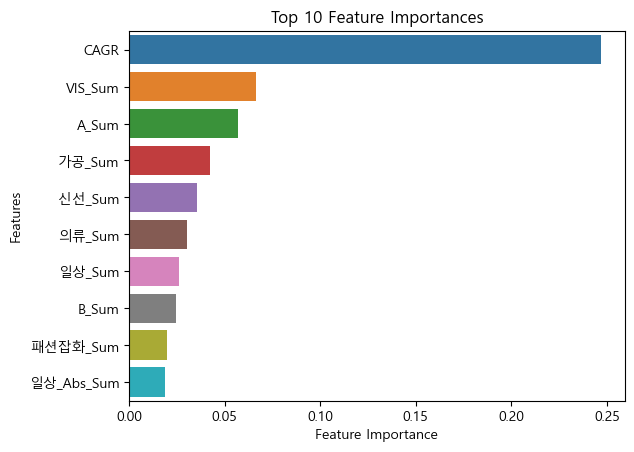

In [101]:
# Sort feature importances in descending order
sorted_indices = np.argsort(rf_clf1.feature_importances_)[::-1]
sorted_importances = rf_clf1.feature_importances_[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

# Plot feature importance
sns.barplot(x=sorted_importances[:10], y=sorted_features[:10])

# Set plot labels
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances")

# Show the plot
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

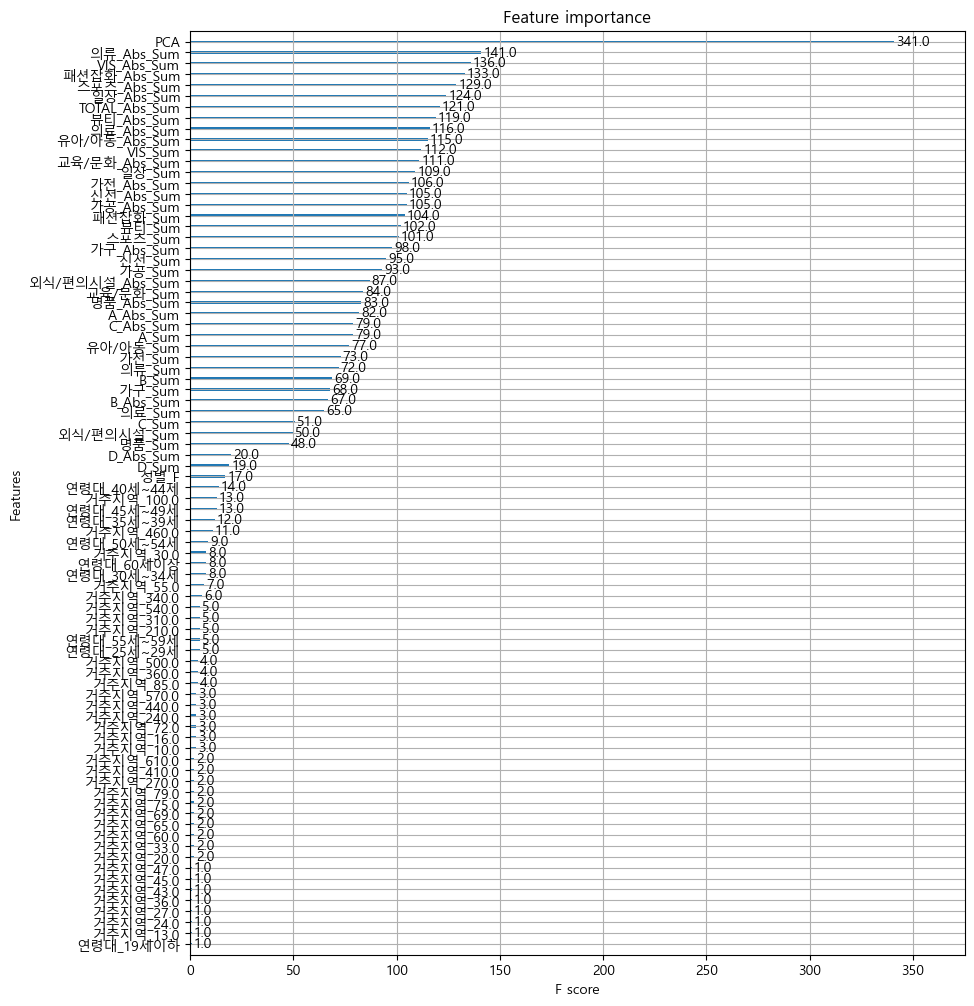

In [176]:
# lightgbm과 겹쳐서 xgboost.을 해줘야 함

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 래퍼 클래스를 입력해도 무방
xgboost.plot_importance(xgb_wrapper, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

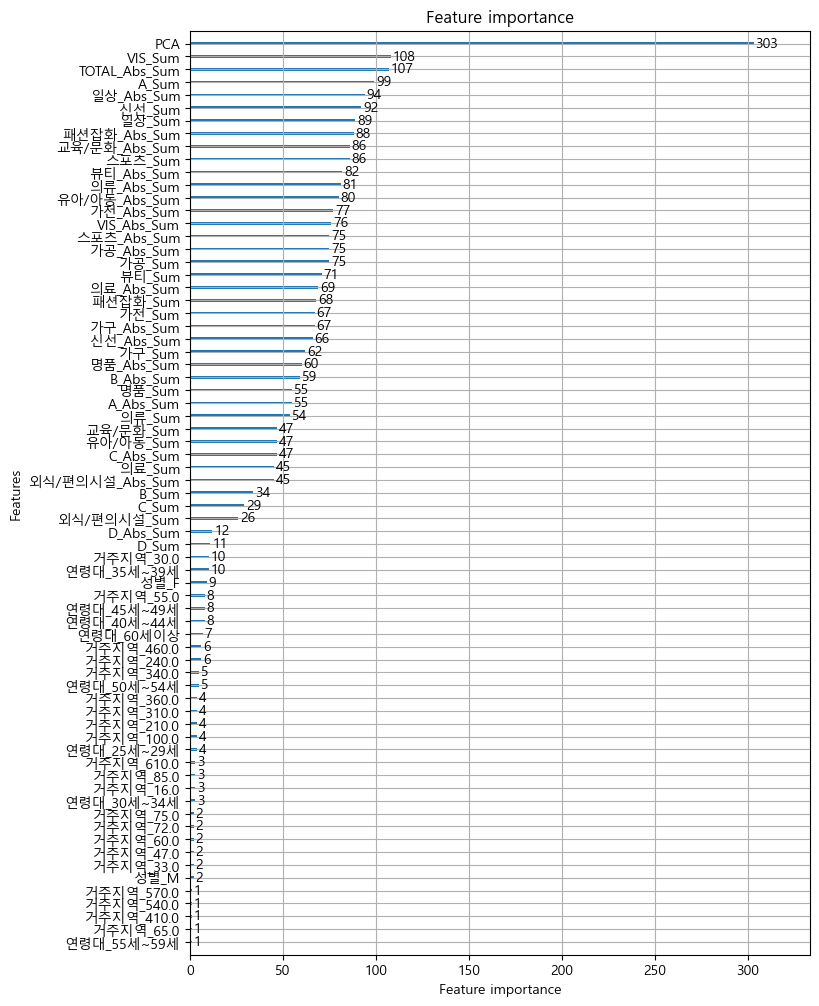

In [177]:
# plot_importance()를 이용하여 fature 중요도 시각화
fig, ax = plt.subplots(figsize=(8,12))
plot_importance(lgbm_wrapper, ax=ax)

<AxesSubplot:>

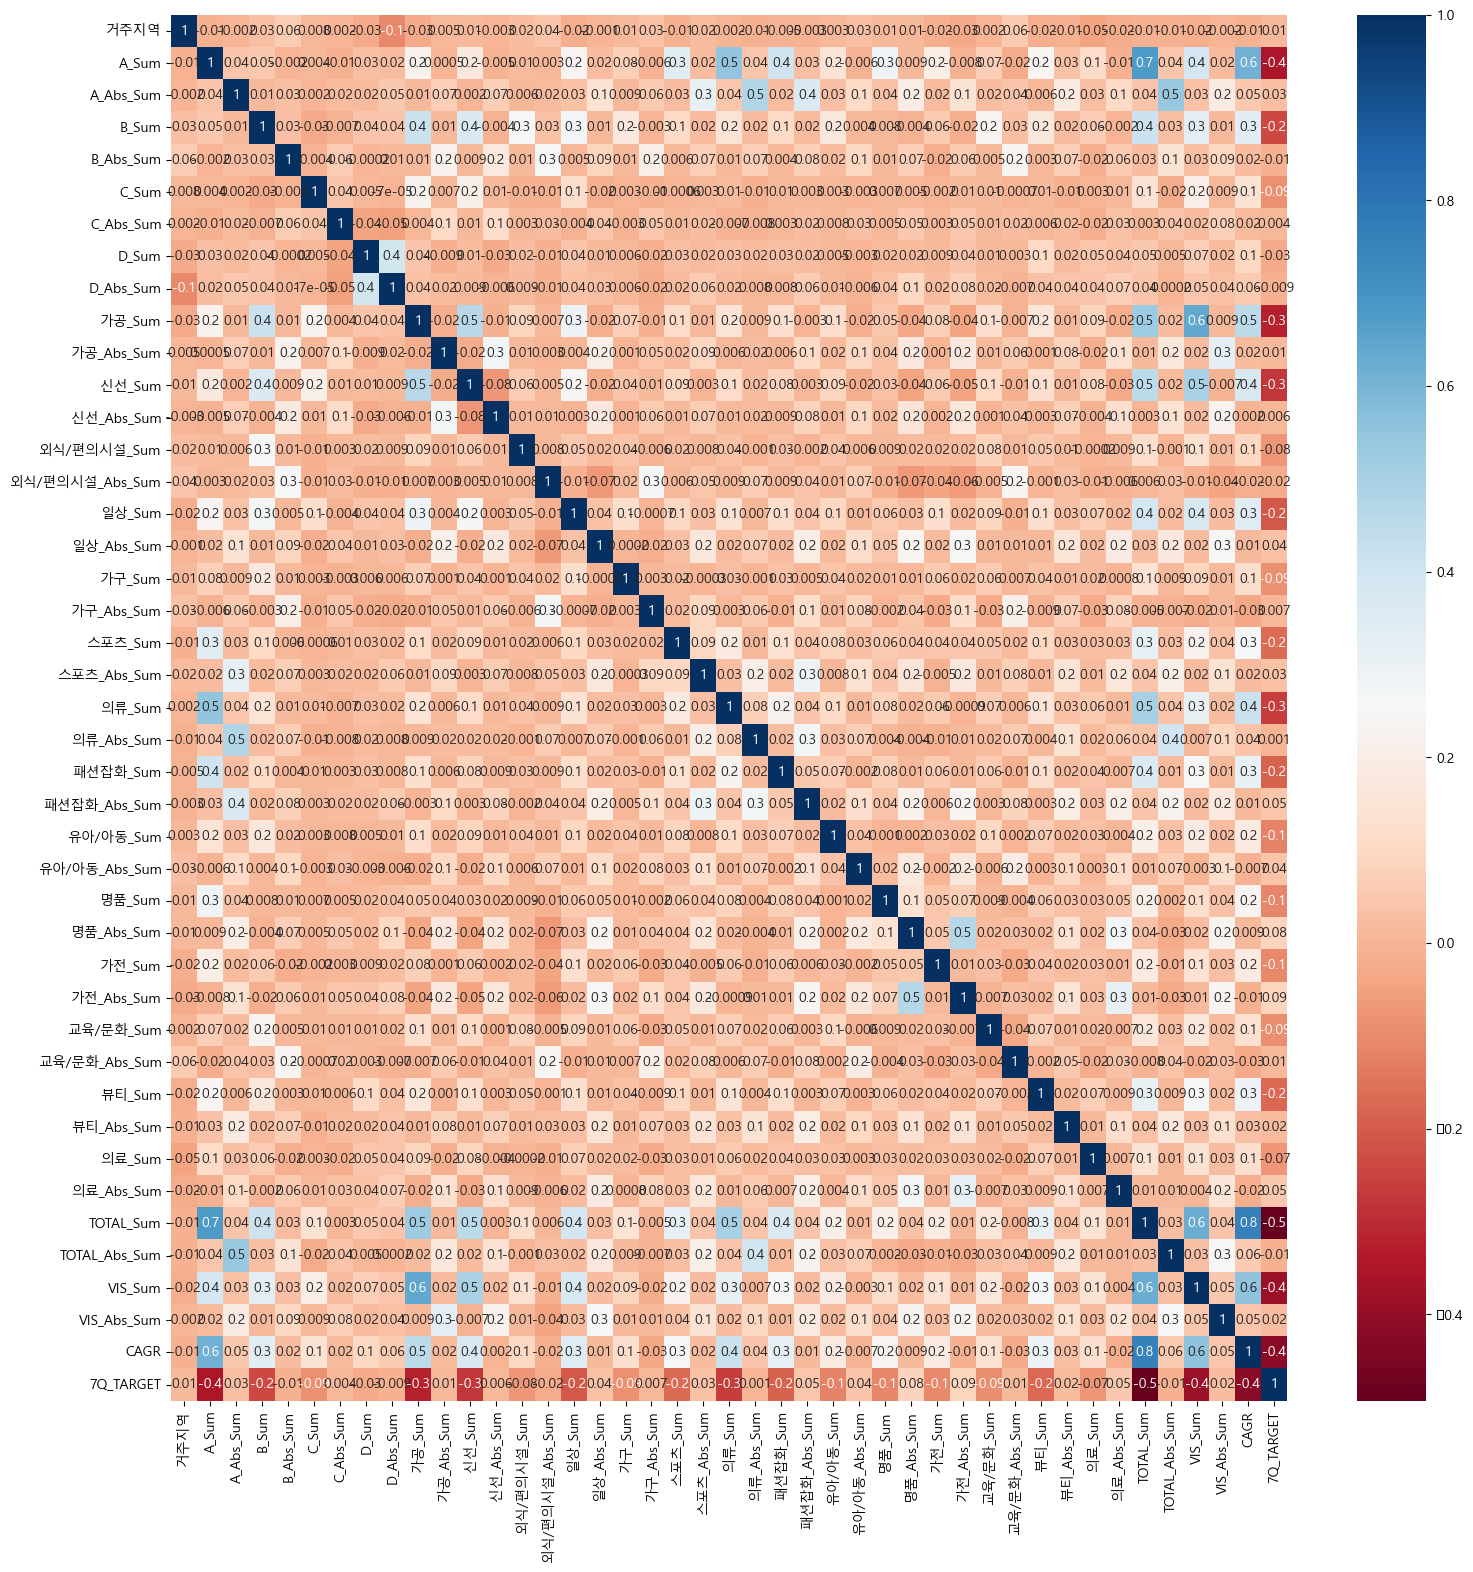

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = X_test_6Q.corr()
plt.figure(figsize=(18,18,))
sns.heatmap(corr, annot=True, fmt='.1g', cmap='RdBu')

<AxesSubplot:>

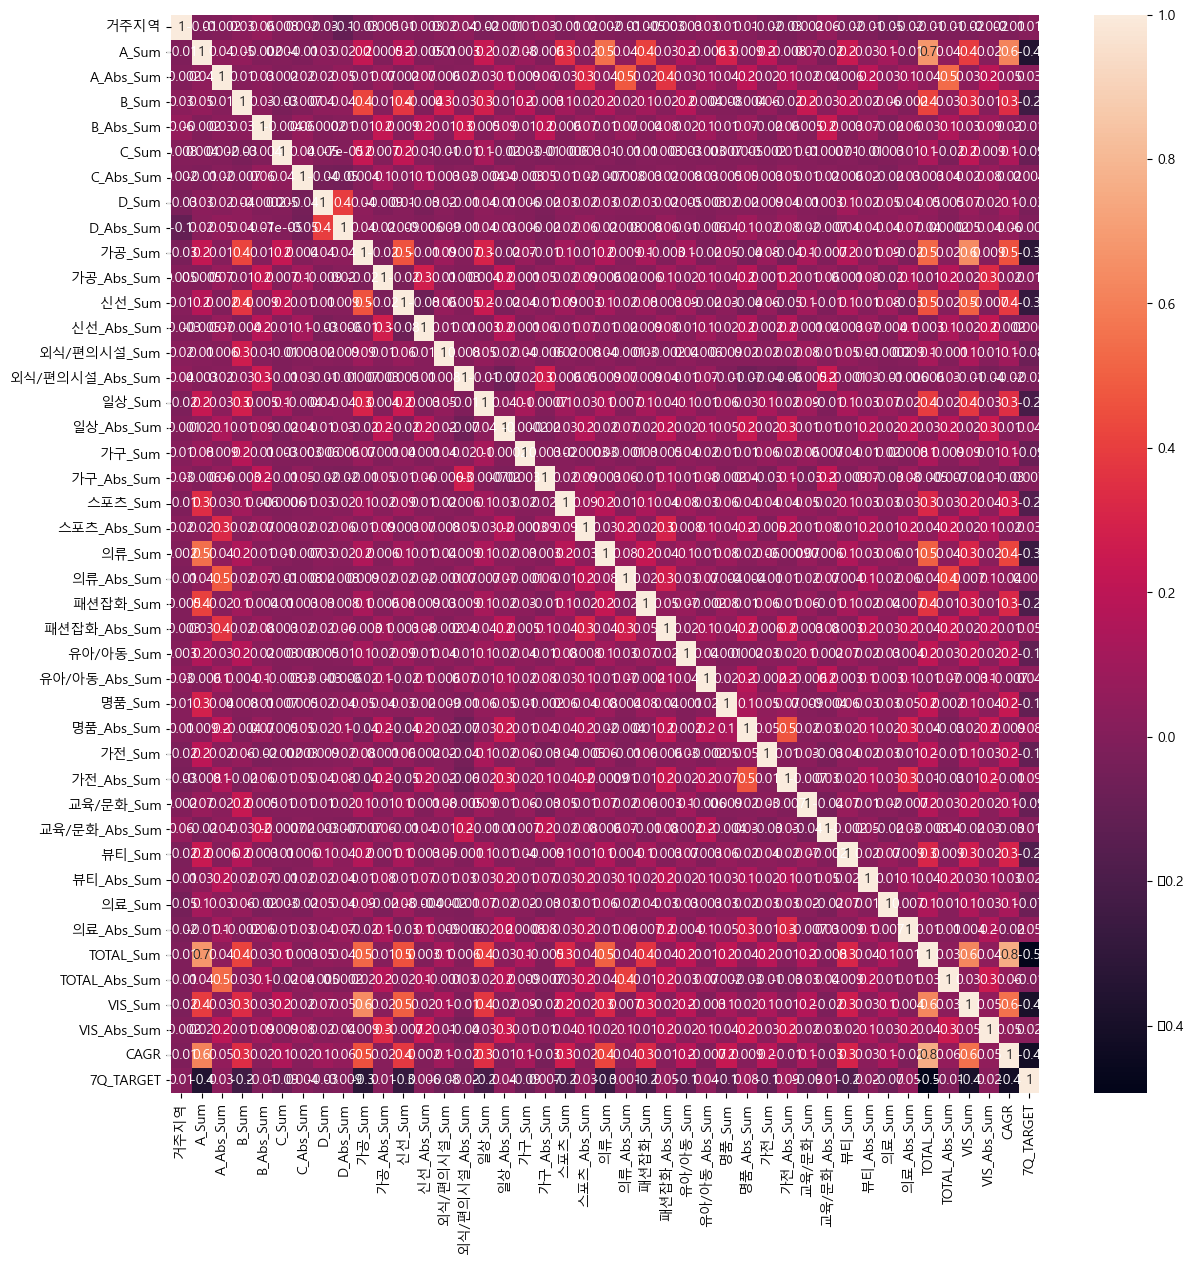

In [179]:
# cols_to_remove = ['연령대_19세이하', '연령대_20세~24세', '연령대_25세~29세', '연령대_30세~34세', '연령대_35세~39세',\
#                    '연령대_40세~44세',  '연령대_45세~49세',  '연령대_50세~54세', '연령대_55세~59세', '연령대_60세이상',\
#                   '성별_F', '성별_M']
# l_df_filtered = l_df.drop(cols_to_remove, axis=1)
# l_df_filtered = l_df_filtered.drop('target', axis=1)

# heatmap 생성
corr = X_test_6Q.corr()
plt.figure(figsize=(14,14,))
sns.heatmap(corr, annot=True, fmt='.1g')

In [ ]:
corr.to_excel('corr.xlsx')
corr

,거주지역,가공_순증감율,가공_변동률,신선_순증감율,신선_변동률,외식/편의시설_순증감율,외식/편의시설_변동률,일상_순증감율,일상_변동률,의료_순증감률,의료_변동률,교육문화_순증감률,교육문화_변동률,뷰티_순증감률,뷰티_변동률,가전_순증감률,가전_변동률,가구_순증가율,가구_변동률,의류_순증가율,의류_변동률,스포츠_순증감률,스포츠_변동률,패션잡화_순증감율,패션잡화_변동률,A_순증감율,A_변동률,B_순증감율,B_변동률,C_순증감율,C_변동률,D_순증감율,D_변동률
거주지역,1.000000,-0.031827,0.000781,-0.004818,-0.001244,0.029022,0.047176,-0.006793,-0.000302,-0.061544,-0.035408,-0.003631,0.069906,-0.016043,-0.013892,-0.008641,-0.027757,0.015576,0.045816,0.012923,-0.012195,-0.019741,0.012930,-0.008288,-0.002198,-0.007295,-0.001634,0.023000,0.072156,0.005386,0.005478,-0.029817,-0.102133
가공_순증감율,-0.031827,1.000000,-0.005953,0.489745,-0.002434,0.099785,-0.009767,0.347011,0.024505,0.116785,0.014138,0.163780,-0.007982,0.211152,0.028305,0.094753,0.016465,0.087984,-0.009489,0.188482,0.000107,0.145897,0.016293,0.162781,0.013052,0.259615,0.008989,0.441623,0.001346,0.246401,-0.000834,0.043623,0.050958
가공_변동률,0.000781,-0.005953,1.000000,-0.043313,0.308163,0.012783,0.011579,0.005939,0.255883,-0.023154,0.157109,0.008085,0.070986,-0.019189,0.110124,0.010875,0.218101,-0.000384,0.076426,0.005044,0.036742,0.013907,0.113883,-0.003235,0.131284,-0.012522,0.076710,-0.004943,0.239846,0.008590,0.134108,-0.039057,0.010872
신선_순증감율,-0.004818,0.489745,-0.043313,1.000000,-0.088637,0.076392,0.000611,0.287395,-0.032050,0.096510,-0.047114,0.117247,-0.020147,0.159733,-0.014385,0.062251,-0.062796,0.070120,0.001204,0.149202,-0.001921,0.107261,-0.015136,0.110605,-0.025875,0.206152,-0.011451,0.403370,-0.009444,0.223153,-0.002272,0.002330,0.000521
신선_변동률,-0.001244,-0.002434,0.308163,-0.088637,1.000000,0.014051,0.017575,0.002440,0.217889,-0.023353,0.160098,-0.007345,0.049258,-0.017337,0.097690,0.005256,0.201317,0.002492,0.079733,0.001795,0.017378,-0.004337,0.085260,-0.003391,0.105100,-0.021859,0.067543,-0.006762,0.193425,0.013726,0.129612,-0.071874,-0.017550
외식/편의시설_순증감율,0.029022,0.099785,0.012783,0.076392,0.014051,1.000000,-0.003531,0.070215,0.024843,0.007125,0.017559,0.110181,0.016767,0.057311,0.010005,0.021358,0.030322,0.034683,-0.003286,0.043745,-0.000247,0.028040,0.009705,0.035845,0.011326,0.016210,0.017448,0.280569,0.002710,-0.006854,0.009259,0.005128,0.013904
외식/편의시설_변동률,0.047176,-0.009767,0.011579,0.000611,0.017575,-0.003531,1.000000,-0.025676,-0.063145,-0.029999,-0.012814,-0.011424,0.278938,-0.031750,0.040204,-0.035194,-0.076531,0.013625,0.313979,0.001129,0.081684,-0.013385,0.065677,-0.017637,0.056395,-0.001811,0.022020,0.022584,0.279667,-0.022097,0.028433,-0.034739,-0.023755
일상_순증감율,-0.006793,0.347011,0.005939,0.287395,0.002440,0.070215,-0.025676,1.000000,0.034598,0.087241,0.020463,0.123477,-0.029495,0.170088,0.016915,0.132840,0.035304,0.132652,-0.010052,0.173652,-0.007869,0.133148,0.013367,0.141815,0.020318,0.266215,0.025110,0.288510,-0.001099,0.129598,0.004438,0.043514,0.041110
일상_변동률,-0.000302,0.024505,0.255883,-0.032050,0.217889,0.024843,-0.063145,0.034598,1.000000,0.006419,0.233235,0.011588,0.026006,-0.011740,0.193796,0.026371,0.305715,0.011806,0.005281,0.016459,0.079947,0.011561,0.210023,-0.007759,0.243303,0.007502,0.156021,0.004099,0.106181,-0.011287,0.064459,-0.018564,0.037402
의료_순증감률,-0.061544,0.116785,-0.023154,0.096510,-0.023353,0.007125,-0.029999,0.087241,0.006419,1.000000,-0.025057,0.035090,-0.027072,0.074752,0.002798,0.029527,0.012647,0.013943,-0.034404,0.073001,0.005320,0.050976,-0.002116,0.066455,0.010795,0.121092,0.010988,0.072092,-0.026826,0.014973,-0.022609,0.052796,0.052577


### 군집화

In [20]:
X_test['CLUSTER'] = lgbm_pred
X_test = X_test.query('CLUSTER == 1')
X_test

,A_Sum,A_Abs_Sum,B_Sum,B_Abs_Sum,C_Sum,C_Abs_Sum,D_Sum,D_Abs_Sum,가공_Sum,가공_Abs_Sum,신선_Sum,신선_Abs_Sum,외식/편의시설_Sum,외식/편의시설_Abs_Sum,일상_Sum,일상_Abs_Sum,가구_Sum,가구_Abs_Sum,스포츠_Sum,스포츠_Abs_Sum,의류_Sum,의류_Abs_Sum,패션잡화_Sum,패션잡화_Abs_Sum,유아/아동_Sum,유아/아동_Abs_Sum,명품_Sum,명품_Abs_Sum,가전_Sum,가전_Abs_Sum,교육/문화_Sum,교육/문화_Abs_Sum,뷰티_Sum,뷰티_Abs_Sum,의료_Sum,의료_Abs_Sum,TOTAL_Abs_Sum,VIS_Sum,VIS_Abs_Sum,CAGR,성별_F,성별_M,연령대_19세이하,연령대_20세~24세,연령대_25세~29세,연령대_30세~34세,연령대_35세~39세,연령대_40세~44세,연령대_45세~49세,연령대_50세~54세,연령대_55세~59세,연령대_60세이상,거주지역_10.0,거주지역_13.0,거주지역_16.0,거주지역_20.0,거주지역_24.0,거주지역_27.0,거주지역_30.0,거주지역_33.0,거주지역_36.0,거주지역_39.0,거주지역_43.0,거주지역_45.0,거주지역_47.0,거주지역_49.0,거주지역_52.0,거주지역_55.0,거주지역_60.0,거주지역_65.0,거주지역_69.0,거주지역_72.0,거주지역_75.0,거주지역_79.0,거주지역_82.0,거주지역_85.0,거주지역_87.0,거주지역_100.0,거주지역_210.0,거주지역_240.0,거주지역_270.0,거주지역_300.0,거주지역_310.0,거주지역_340.0,거주지역_360.0,거주지역_410.0,거주지역_440.0,거주지역_460.0,거주지역_500.0,거주지역_540.0,거주지역_570.0,거주지역_610.0,거주지역_630.0,CLUSTER
2,-1,7,0,2,0,0,8,8,-9,11,-1,1,0,0,0,8,0,14,-1,7,0,6,-1,7,-5,27,0,12,-6,26,0,0,0,0,0,14,3,-5,13,-0.100079,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6,1,3,-2,2,-4,14,0,0,-2,8,-4,10,-1,5,-7,11,0,16,0,0,1,5,3,7,0,0,1,3,0,0,2,10,0,4,-3,5,1,-2,6,0.062060,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10,0,8,3,5,-1,1,4,4,-1,1,0,4,0,0,1,7,0,2,0,6,-2,14,4,6,0,0,0,6,0,0,-4,8,-1,25,0,0,5,0,4,-0.016443,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14,1,5,-2,2,0,2,0,0,5,15,-1,5,0,28,-3,15,-8,8,0,8,-1,5,3,11,-3,3,6,8,2,14,0,0,-2,2,0,14,4,1,7,0.063571,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
18,-6,8,1,3,1,11,0,0,-2,12,0,12,0,0,1,15,0,0,0,22,-9,9,-9,13,0,12,0,8,-7,7,0,0,-2,8,1,15,14,-9,9,-0.600347,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19316,2,12,-2,2,0,0,0,0,1,5,-1,7,3,11,-5,9,-6,10,1,13,0,6,1,17,0,4,0,0,-5,5,0,16,-3,13,0,14,9,0,14,-0.028716,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
19320,0,0,0,2,0,0,0,0,-3,7,-2,2,0,18,2,12,3,15,-2,16,-3,7,1,11,2,6,0,0,0,12,0,2,6,16,-2,2,5,-1,5,-0.008792,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
19327,0,0,0,0,0,6,0,0,-1,11,1,9,0,0,0,4,0,0,-2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,-1,7,0.006917,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
19333,-1,3,-1,3,0,0,9,9,-4,10,-1,3,0,0,0,0,0,0,-2,2,-1,1,0,0,0,0,0,0,0,0,-5,5,0,0,7,9,2,-5,15,-0.026446,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


NameError: name 'X_test' is not defined

In [22]:
X_test.values

array([[-1.,  7.,  0., ...,  0.,  0.,  1.],
       [ 1.,  3., -2., ...,  0.,  0.,  1.],
       [ 0.,  8.,  3., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [-1.,  3., -1., ...,  0.,  0.,  1.],
       [ 0.,  0., -1., ...,  0.,  0.,  1.]])

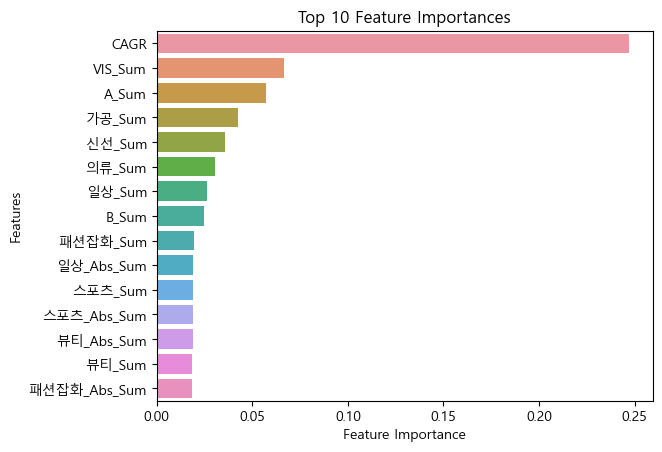

In [86]:
# Sort feature importances in descending order
sorted_indices = np.argsort(rf_clf1.feature_importances_)[::-1]
sorted_importances = rf_clf1.feature_importances_[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

# Plot feature importance
sns.barplot(x=sorted_importances[:15], y=sorted_features[:15])

# Set plot labels
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances")

# Show the plot
plt.show()

In [102]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# 임포턴스가 팍 떨어지기 전의 컬럼까지 넣어 보기
# X_features = X_test['CAGR'].values.reshape(-1,1)
X_features = X_test[['VIS_Sum', 'A_Sum']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
X_test['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.546


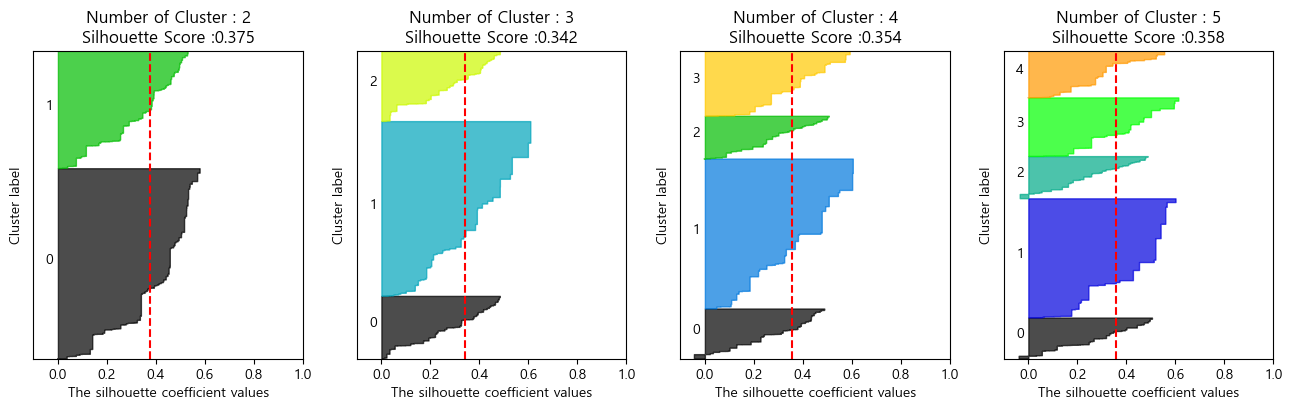

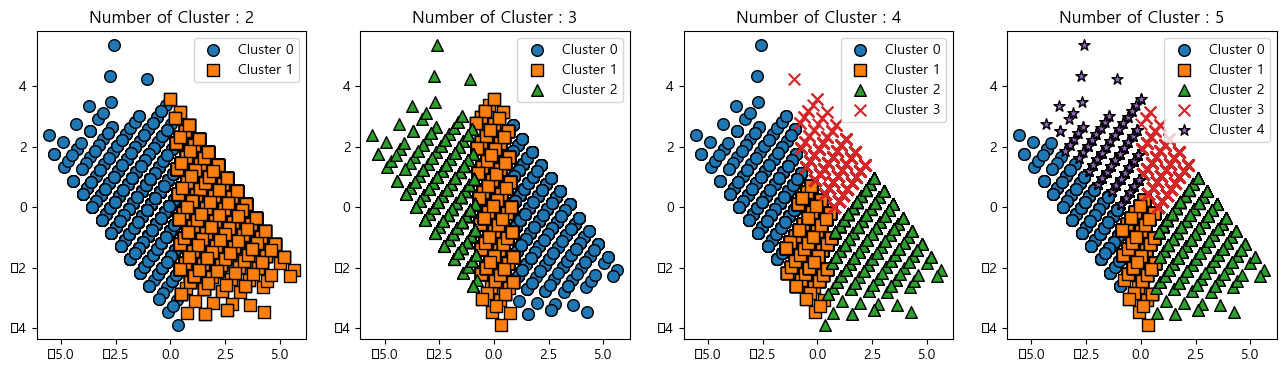

In [96]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

In [26]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [27]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

In [97]:
# 분기별 구개금액이 0인 고객 제거한 master_set 불러오기

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

master_set = pd.read_excel('master_set.xlsx', index_col=0)
master_set.head()

,가공1Q,가공2Q,가공3Q,가공4Q,가공5Q,가공6Q,가공7Q,가공8Q,신선1Q,신선2Q,신선3Q,신선4Q,신선5Q,신선6Q,신선7Q,신선8Q,외식/편의시설1Q,외식/편의시설2Q,외식/편의시설3Q,외식/편의시설4Q,외식/편의시설5Q,외식/편의시설6Q,외식/편의시설7Q,외식/편의시설8Q,일상1Q,일상2Q,일상3Q,일상4Q,일상5Q,일상6Q,일상7Q,일상8Q,의료1Q,의료2Q,의료3Q,의료4Q,의료5Q,의료6Q,의료7Q,의료8Q,교육/문화1Q,교육/문화2Q,교육/문화3Q,교육/문화4Q,교육/문화5Q,교육/문화6Q,교육/문화7Q,교육/문화8Q,뷰티1Q,뷰티2Q,뷰티3Q,뷰티4Q,뷰티5Q,뷰티6Q,뷰티7Q,뷰티8Q,가전1Q,가전2Q,가전3Q,가전4Q,가전5Q,가전6Q,가전7Q,가전8Q,가구1Q,가구2Q,가구3Q,가구4Q,가구5Q,가구6Q,가구7Q,가구8Q,의류1Q,의류2Q,의류3Q,의류4Q,의류5Q,의류6Q,의류7Q,의류8Q,스포츠1Q,스포츠2Q,스포츠3Q,스포츠4Q,스포츠5Q,스포츠6Q,스포츠7Q,스포츠8Q,패션잡화1Q,패션잡화2Q,패션잡화3Q,패션잡화4Q,패션잡화5Q,패션잡화6Q,패션잡화7Q,패션잡화8Q,유아/아동1Q,유아/아동2Q,유아/아동3Q,유아/아동4Q,유아/아동5Q,유아/아동6Q,유아/아동7Q,유아/아동8Q,명품1Q,명품2Q,명품3Q,명품4Q,명품5Q,명품6Q,명품7Q,명품8Q,A1Q,A2Q,A3Q,A4Q,A5Q,A6Q,A7Q,A8Q,B1Q,B2Q,B3Q,B4Q,B5Q,B6Q,B7Q,B8Q,C1Q,C2Q,C3Q,C4Q,C5Q,C6Q,C7Q,C8Q,D1Q,D2Q,D3Q,D4Q,D5Q,D6Q,D7Q,D8Q,TOTAL1Q,TOTAL2Q,TOTAL3Q,TOTAL4Q,TOTAL5Q,TOTAL6Q,TOTAL7Q,TOTAL8Q,VIS1Q,VIS2Q,VIS3Q,VIS4Q,VIS5Q,VIS6Q,VIS7Q,VIS8Q
고객번호,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.877151e+05,366192.084776,733992.532409,826031.841207,1.099272e+06,628006.449843,466150.685252,169232.914472,4.272196e+05,7.103911e+05,2.729306e+05,9.826185e+05,6.563172e+05,526052.844084,1.320830e+05,2.261383e+05,22038.824744,0.000000,0.0,54538.234251,0.0,0.000000,45870.693653,65465.220900,6.844369e+05,20368.592311,2.861113e+06,5.398018e+06,4.549198e+05,6.724150e+05,0.000000e+00,822144.541531,869421.526600,1.923067e+06,192595.479377,26108.729163,0.0,0.000000,0.000000,94668.317964,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.157797e+06,5.475882e+05,6.871389e+05,4.345653e+05,5.282241e+05,7.845680e+04,0.000000e+00,6.778600e+04,0.000000,0.000000e+00,10136.604178,8.753387e+06,2.941880e+05,0.0,1.843019e+06,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,4.370784e+06,4.397041e+06,5.853735e+06,4.876579e+06,4.590788e+06,6.390296e+06,4.358545e+06,3.302425e+06,7.145432e+05,1.444812e+06,0.000000e+00,0.000000,5.153142e+05,90778.541040,2.402580e+05,145048.495348,402906.110710,1.363308e+06,427580.394406,1.212634e+06,756861.767563,259712.125170,907226.073907,228209.632681,104876.499034,74151.734576,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,5.090160e+05,0.000000,0.000000,0.000000,9.219700e+06,1.064540e+07,1.097841e+07,2.187151e+07,9.105745e+06,8.424731e+06,7.876746e+06,4.939385e+06,22038.824744,0.000000,4.812327e+03,359178.754080,1.917135e+05,18608.343593,1.141648e+05,7.097706e+04,0.000000,201518.302545,55997.058836,333787.531474,107443.314448,202378.309776,2242.339712,110757.097068,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,9.241739e+06,1.084692e+07,1.103922e+07,2.256448e+07,9.404902e+06,8.645718e+06,7.993153e+06,5.121119e+06,77,82,100,119,111,74,68,50
2,1.006891e+06,555333.324191,760255.552324,592126.637609,4.984414e+05,184896.525363,450597.653185,571607.110467,1.932198e+06,1.684548e+06,1.127917e+06,1.182948e+06,1.425639e+06,761111.428634,8.788231e+05,1.026963e+06,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.339667e+06,443089.807353,3.364759e+06,1.979912e+05,2.292038e+05,2.176804e+06,1.086152e+06,514960.838084,0.000000,2.212381e+05,0.000000,0.000000,0.0,0.000000,57133.587184,76392.207550,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.513305e+06,2.015636e+06,2.536660e+06,1.624495e+06,3.729151e+06,3.676073e+06,2.584578e+06,3.401378e+06,298231.802729,1.133298e+06,704442.795382,0.000000e+00,1.901607e+06,0.0,3.462469e+06,0.0,0.0,0.000000,0.000000,29009.699070,85729.006344,0.0,0.000000,0.000000,1.518404e+06,1.491655e+06,3.769056e+06,2.124148e+06,5.872669e+06,1.599714e+06,3.682147e+06,5.203141e+06,2.218369e+06,1.765711e+06,2.320115e+06,427032.440204,1.799692e+06,646393.505026,1.199416e+06,517184.915012,335960.653162,5.944611e+05,499355.743180,2.496091e+05,530518.993621,319661.167230,698493.939798,293433.106089,115168.023617,354524.150415,113314.947914,0.000000,1.050474e+06,0.000000,7361

,가공1Q,가공2Q,가공3Q,가공4Q,가공5Q,가공6Q,신선1Q,신선2Q,신선3Q,신선4Q,신선5Q,신선6Q,외식/편의시설1Q,외식/편의시설2Q,외식/편의시설3Q,외식/편의시설4Q,외식/편의시설5Q,외식/편의시설6Q,일상1Q,일상2Q,일상3Q,일상4Q,일상5Q,일상6Q,의료1Q,의료2Q,의료3Q,의료4Q,의료5Q,의료6Q,교육/문화1Q,교육/문화2Q,교육/문화3Q,교육/문화4Q,교육/문화5Q,교육/문화6Q,뷰티1Q,뷰티2Q,뷰티3Q,뷰티4Q,뷰티5Q,뷰티6Q,가전1Q,가전2Q,가전3Q,가전4Q,가전5Q,가전6Q,가구1Q,가구2Q,가구3Q,가구4Q,가구5Q,가구6Q,의류1Q,의류2Q,의류3Q,의류4Q,의류5Q,의류6Q,스포츠1Q,스포츠2Q,스포츠3Q,스포츠4Q,스포츠5Q,스포츠6Q,패션잡화1Q,패션잡화2Q,패션잡화3Q,패션잡화4Q,패션잡화5Q,패션잡화6Q,유아/아동1Q,유아/아동2Q,유아/아동3Q,유아/아동4Q,유아/아동5Q,유아/아동6Q,명품1Q,명품2Q,명품3Q,명품4Q,명품5Q,명품6Q,A1Q,A2Q,A3Q,A4Q,A5Q,A6Q,B1Q,B2Q,B3Q,B4Q,B5Q,B6Q,C1Q,C2Q,C3Q,C4Q,C5Q,C6Q,D1Q,D2Q,D3Q,D4Q,D5Q,D6Q,TOTAL1Q,TOTAL2Q,TOTAL3Q,TOTAL4Q,TOTAL5Q,TOTAL6Q,VIS1Q,VIS2Q,VIS3Q,VIS4Q,VIS5Q,VIS6Q
고객번호,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.877151e+05,366192.084776,733992.532409,826031.841207,1.099272e+06,628006.449843,4.272196e+05,7.103911e+05,2.729306e+05,9.826185e+05,6.563172e+05,526052.844084,22038.824744,0.000000,0.000000,54538.234251,0.000000,0.000000,6.844369e+05,20368.592311,2.861113e+06,5.398018e+06,4.549198e+05,6.724150e+05,869421.526600,1.923067e+06,192595.479377,26108.729163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.157797e+06,5.475882e+05,6.871389e+05,4.345653e+05,5.282241e+05,7.845680e+04,0.000000,0.000000e+00,10136.604178,8.753387e+06,2.941880e+05,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,4.370784e+06,4.397041e+06,5.853735e+06,4.876579e+06,4.590788e+06,6.390296e+06,7.145432e+05,1.444812e+06,0.000000e+00,0.000000,5.153142e+05,90778.541040,402906.110710,1.363308e+06,427580.394406,1.212634e+06,756861.767563,259712.125170,104876.499034,74151.734576,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.000000,5.090160e+05,0.000000,9.219700e+06,1.064540e+07,1.097841e+07,2.187151e+07,9.105745e+06,8.424731e+06,22038.824744,0.000000e+00,4.812327e+03,3.591788e+05,1.917135e+05,1.860834e+04,0.000000,201518.302545,55997.058836,333787.531474,107443.314448,202378.309776,0.0,0.000000,0.0,0.0,0.000000,0.000000,9.241739e+06,1.084692e+07,1.103922e+07,2.256448e+07,9.404902e+06,8.645718e+06,77,82,100,119,111,74
2,1.006891e+06,555333.324191,760255.552324,592126.637609,4.984414e+05,184896.525363,1.932198e+06,1.684548e+06,1.127917e+06,1.182948e+06,1.425639e+06,761111.428634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.339667e+06,443089.807353,3.364759e+06,1.979912e+05,2.292038e+05,2.176804e+06,0.000000,2.212381e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.513305e+06,2.015636e+06,2.536660e+06,1.624495e+06,3.729151e+06,3.676073e+06,298231.802729,1.133298e+06,704442.795382,0.000000e+00,1.901607e+06,0.0,0.000000,0.000000,0.000000,29009.699070,85729.006344,0.00000,1.518404e+06,1.491655e+06,3.769056e+06,2.124148e+06,5.872669e+06,1.599714e+06,2.218369e+06,1.765711e+06,2.320115e+06,427032.440204,1.799692e+06,646393.505026,335960.653162,5.944611e+05,499355.743180,2.496091e+05,530518.993621,319661.167230,115168.023617,354524.150415,113314.947914,0.000000,1.050474e+06,0.000000,0.0,0.000000,0.000000,419818.695035,1.560824e+06,0.000000,1.424736e+07,1.025949e+07,1.519588e+07,6.802262e+06,1.858811e+07,9.153263e+06,30834.135536,0.000000e+00,0.000000e+00,4.491668e+04,9.583856e+04,3.792079e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,173469.996540,1.427820e+07,1.025949e+07,1.519588e+07,6.847179e+06,1.868395e+07,9.364654e+06,103,85,95,72,95,71
3,1.982888e+05,341327.314311,356286.278356,256474.749474,1.523105e+05,221026.887625,8.385065e+04,1.073681e+05,2.209247e+05,4.817157e+04,9.472651e+04,63006.845548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.395964e+04,10440.789540,8.646831e+04,7.670164e+04,3.533289e+04,3.076915e+04,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.204010e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0000